In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def datapreparation(filepath):
    df = pd.read_csv(filepath)
    df.drop(["CustomerID",'Churn_Label'], inplace = True, axis = 1)
    df.Total_Charges = df.Total_Charges.replace(" ",np.nan)
    df.Total_Charges.fillna(0, inplace = True)
    df.Total_Charges = df.Total_Charges.astype(float)
    cols1 = ['Partner', 'Dependents', 'Paperless_Billing', 'Phone_Service']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
    df.Gender = df.Gender.apply(lambda x: 0 if x == "Male" else 1)
    df.Multiple_Lines = df.Multiple_Lines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    cols2 = ['Senior_Citizen','Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    df = pd.get_dummies(df, columns=['Internet_Service', 'Contract', 'Payment_Method'], drop_first=True)
    return df

In [4]:
df_churn = datapreparation(filepath = "Telco_Customer_Churn_Survival_Analysis_Churn.csv")
df_churn.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Monthly_Charges,Total_Charges,Churn_Value,Internet_Service_Fiber optic,Internet_Service_No,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,0,0,0,0,4,1,0,0,0,1,...,73.9,280.85,1,1,0,0,0,0,1,0
1,0,1,1,0,13,1,0,0,1,1,...,98.0,1237.85,1,1,0,0,0,0,1,0
2,1,1,1,0,3,1,0,0,0,0,...,83.9,267.40,1,1,0,0,0,0,0,1
3,0,1,0,0,45,1,0,1,0,1,...,62.7,2791.50,1,0,0,1,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,...,25.1,25.10,1,0,0,0,0,0,1,0


In [19]:
df_not_churn = datapreparation(filepath = "Telco_Customer_Churn_Survival_Analysis_NotChurn.csv")
df_churn.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Monthly_Charges,Total_Charges,Churn_Value,Internet_Service_Fiber optic,Internet_Service_No,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,0,0,0,0,4,1,0,0,0,1,...,73.9,280.85,1,1,0,0,0,0,1,0
1,0,1,1,0,13,1,0,0,1,1,...,98.0,1237.85,1,1,0,0,0,0,1,0
2,1,1,1,0,3,1,0,0,0,0,...,83.9,267.40,1,1,0,0,0,0,0,1
3,0,1,0,0,45,1,0,1,0,1,...,62.7,2791.50,1,0,0,1,0,1,0,0
4,0,1,0,0,1,0,0,0,0,0,...,25.1,25.10,1,0,0,0,0,0,1,0


In [6]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OneHotEncoder 
from lifelines import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance

将已发生终点事件（主动流失）的客户作为训练集，将未发生终点事件（删失数据）作为测试集。

In [15]:
x_train=df_churn[['Gender','Senior_Citizen','Partner','Dependents','Phone_Service',
      'Multiple_Lines','Online_Security','Online_Backup','Device_Protection',
      'Tech_Support','Streaming_TV','Streaming_Movies','Paperless_Billing',
      'Monthly_Charges','Total_Charges',
      'Internet_Service_Fiber optic','Internet_Service_No','Contract_One year',
      'Contract_Two year','Payment_Method_Credit card (automatic)',
      'Payment_Method_Electronic check','Payment_Method_Mailed check']]
y_train=df_churn["Tenure_Months"]

x_test=df_not_churn[['Gender','Senior_Citizen','Partner','Dependents','Phone_Service',
      'Multiple_Lines','Online_Security','Online_Backup','Device_Protection',
      'Tech_Support','Streaming_TV','Streaming_Movies','Paperless_Billing',
      'Monthly_Charges','Total_Charges',
      'Internet_Service_Fiber optic','Internet_Service_No','Contract_One year',
      'Contract_Two year','Payment_Method_Credit card (automatic)',
      'Payment_Method_Electronic check','Payment_Method_Mailed check']]
y_test=df_not_churn["Tenure_Months"]

In [20]:
model = RandomForestRegressor(n_estimators=700,random_state=0).fit(x_train,y_train)

In [21]:
y_pred = model.predict(x_test)

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.23944584575403197
Mean Squared Error: 0.219083924613184
Root Mean Squared Error: 0.4680640176441509


In [12]:
import shap 
shap.initjs()

import joblib
explainer = shap.TreeExplainer(model)

https://blog.csdn.net/sinat_26917383/article/details/115400327

https://blog.csdn.net/sinat_26917383/article/details/115556182

https://zhuanlan.zhihu.com/p/85791430

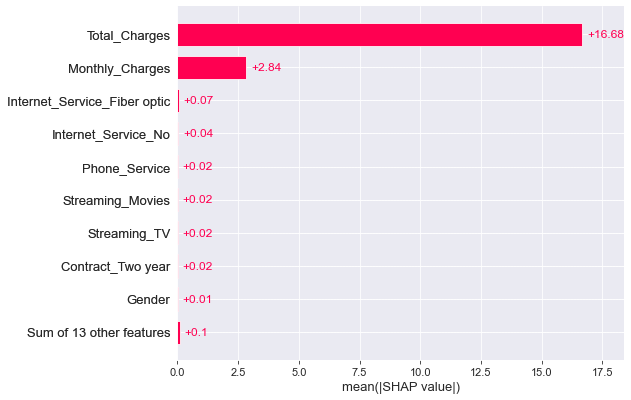

In [26]:
shap_values = explainer(x_train)
shap.plots.bar(shap_values)

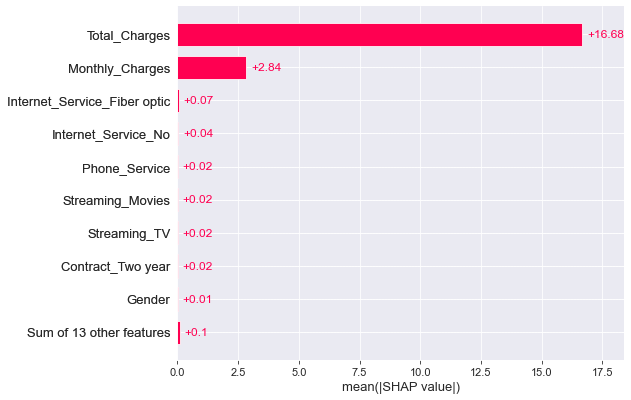

In [27]:
shap_values = explainer(x_test)
shap.plots.bar(shap_values)

结论：
 - TotalCharge不属于客户自身属性，在客户服务初期，TotalCharges对企业识别该客户是否值得长期关注帮助不大，应尝试删除

### Delete Total Charge 

In [20]:
x_train=df_churn[['Gender','Senior_Citizen','Partner','Dependents','Phone_Service',
      'Multiple_Lines','Online_Security','Online_Backup','Device_Protection',
      'Tech_Support','Streaming_TV','Streaming_Movies','Paperless_Billing',
      'Monthly_Charges',
      'Internet_Service_Fiber optic','Internet_Service_No','Contract_One year',
      'Contract_Two year','Payment_Method_Credit card (automatic)',
      'Payment_Method_Electronic check','Payment_Method_Mailed check']]
y_train=df_churn["Tenure_Months"]

x_test=df_not_churn[['Gender','Senior_Citizen','Partner','Dependents','Phone_Service',
      'Multiple_Lines','Online_Security','Online_Backup','Device_Protection',
      'Tech_Support','Streaming_TV','Streaming_Movies','Paperless_Billing',
      'Monthly_Charges',
      'Internet_Service_Fiber optic','Internet_Service_No','Contract_One year',
      'Contract_Two year','Payment_Method_Credit card (automatic)',
      'Payment_Method_Electronic check','Payment_Method_Mailed check']]
y_test=df_not_churn["Tenure_Months"]

In [21]:
model = RandomForestRegressor(n_estimators=700,random_state=0).fit(x_train,y_train)

In [22]:
y_pred = model.predict(x_test)

In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:',
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 13.007318368617902
Mean Squared Error: 294.1203126791649
Root Mean Squared Error: 17.1499362295947


In [24]:
explainer = shap.TreeExplainer(model)

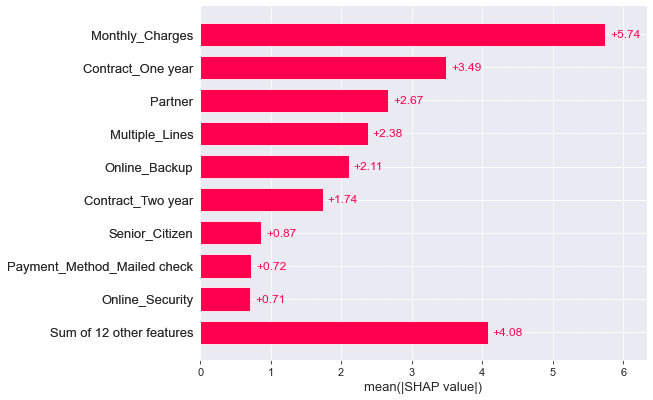

In [14]:
shap_values = explainer(x_train)
shap.plots.bar(shap_values)

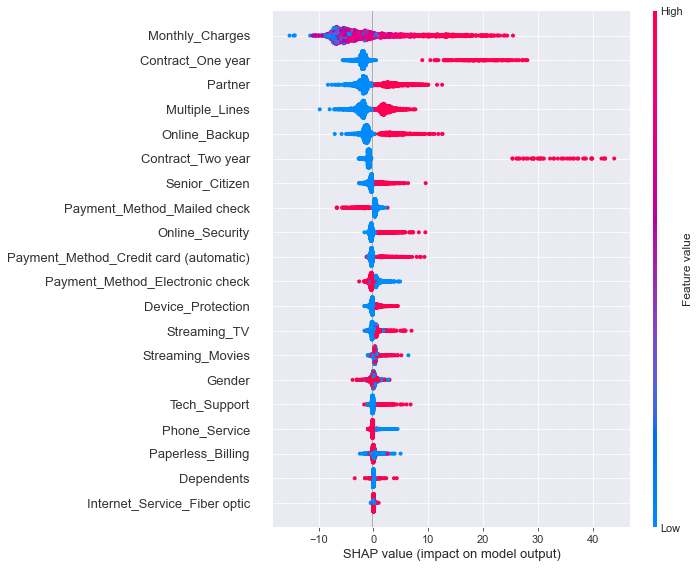

In [15]:
shap.summary_plot(shap_values)

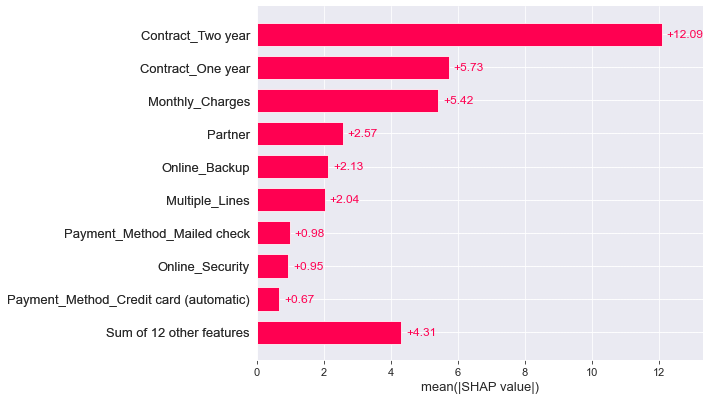

In [25]:
shap_values = explainer(x_test)
shap.plots.bar(shap_values)

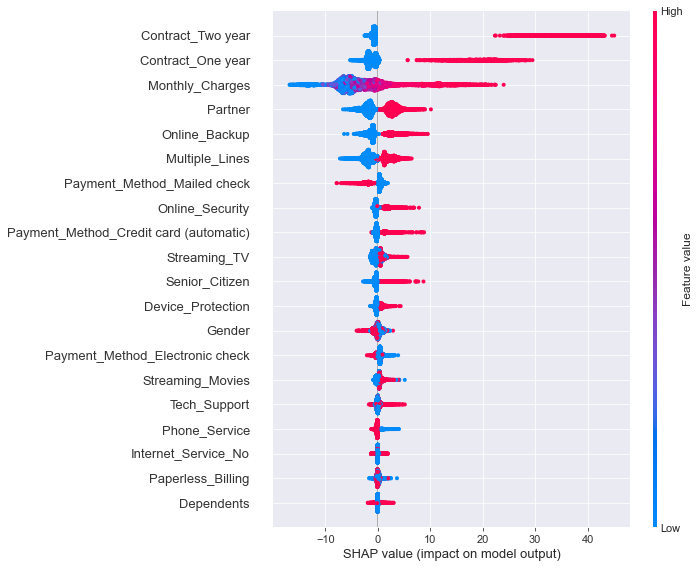

In [26]:
shap.summary_plot(shap_values)

In [27]:
#48  70
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x_test.iloc[47]))
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[47])

In [28]:
#93  30
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x_test.iloc[92]))
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[92])

In [29]:
#120   3
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x_test.iloc[119]))
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[119])

In [30]:
#129 7
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(np.array(x_test.iloc[128]))
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[128])